In [16]:
import importlib
import pandas as pd
import random
import re
import zss
import sexpdata
import coq_serapy
from numpy import NaN
from numpy import mean
import utils
import log_parser
import generate_dataframes
importlib.reload(utils)
importlib.reload(log_parser)
importlib.reload(generate_dataframes)


<module 'generate_dataframes' from '/home/yousef/lemmaranker/generate_dataframes.py'>

In [5]:
def sexp_size(sexp):
  if isinstance(sexp, list):
    return sum(sexp_size(child) for child in sexp)
  else:
    return 1

def sexp_to_tree(sexp):
  if isinstance(sexp, list):
    tree = zss.Node(sexp[0])
    for i in range(1, len(sexp)):
      tree.addkid(sexp_to_tree(sexp[i]))
    return tree
  else:
    return zss.Node(sexp)

def ted_distance(s1, s2):
  return zss.distance(sexp_to_tree(sexpdata.loads(s1)), sexp_to_tree(sexpdata.loads(s2)), zss.Node.get_children, insert_cost, remove_cost, update_cost1)
  return zss.simple_distance(sexp_to_tree(s1), sexp_to_tree(s2), zss.Node.get_children, zss.Node.get_label, my_label_distance)

def insert_cost(n):
  return depth(n)

def remove_cost(n):
  return depth(n)

def update_cost1(n1, n2):
  return my_label_distance(zss.Node.get_label(n1), zss.Node.get_label(n2)) + abs(depth(n1) - depth(n2))

def update_cost2(n1, n2):
  children1 = zss.Node.get_children(n1)
  children2 = zss.Node.get_children(n2)
  if not children1:
    return depth(n2)
  if not children2:
    return depth(n1)
  dist = my_label_distance(zss.Node.get_label(n1), zss.Node.get_label(n2))
  if len(children1) > len(children2):
    small = children2
    big = children1
  else:
    small = children1
    big = children2
  for i in range(len(small)):
    dist += update_cost2(big[i], small[i])
  for i in range(len(small), len(big)):
    dist += insert_cost(big[i])
  return dist


def my_label_distance(l1, l2):
  if l1 == l2:
    return 0
  else:
    return 1

def depth(tree : zss.Node):
  if not zss.Node.get_children(tree):
    return 1
  else:
    return 1 + max(depth(child) for child in zss.Node.get_children(tree))

In [6]:
def ted(t1, t2):
  return ted_distance(t1, t2)

def sed(s1, s2):
  import editdistance
  return editdistance.eval(s1, s2)

def get_thereorem_body(s):
  if match := re.match(f'(Lemma|Theorem) (\w+)[ ]?:(?P<body>.+)', s):
    return match.groupdict()["body"].strip()
  else:
    return s

def get_goal(s):
  if match := re.match(f'(.*)(forall|exists) (.+),(?P<goal>[\w\W]+)', s):
    return match.groupdict()["goal"].strip()
  else:
    return s

In [7]:
df = pd.read_pickle('./smallclam.pickle')

In [8]:
frames = []
for filename in df["file"].unique():
  frame = df[df["file"] == filename]
  if 1 in frame['cat'].unique():
    continue
  elif frame['is_equiv'].any():
    frames.append(frame)
  else:
    print(f"Excluding file: {filename} because none of the synthesized lemmas are equivalent to human lemma")
frames = sorted(frames, key=lambda frame: frame.file[0])
for frame in frames:
  print(frame.at[0, 'file'])

Excluding file: smallclam_lf_goal33_mult_succ_82_plus_assoc because none of the synthesized lemmas are equivalent to human lemma
Excluding file: smallclam_lf_goal33_mult_succ_81_plus_assoc because none of the synthesized lemmas are equivalent to human lemma
smallclam_lf_goal17_theorem0_40_lem
smallclam_lf_goal18_theorem0_41_append_assoc
smallclam_lf_goal21_theorem0_49_append_assoc
smallclam_lf_goal32_rotate_len_append_51_append_assoc
smallclam_lf_goal34_plus_qmult_66_plus_commut
smallclam_lf_goal79_theorem0_43_append_assoc
smallclam_lf_goal7_theorem0_54_plus_comm
smallclam_lf_goal7_theorem0_58_plus_comm
smallclam_lf_goal83_theorem0_50_append_assoc


In [9]:
for i in range(len(frames)):
  print(frames[i].is_equiv.any())

True
True
True
True
True
True
True
True
True


In [87]:
def random_rank(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for iter in range(100):
      for i, _ in frames[index].iterrows():
        frames[index].loc[i, 'alpha'] = random.uniform(0,1)    
      all_equiv = []
      sorted_frame = frames[index].sort_values('alpha', ascending=False, ignore_index=True)
      for i, row in sorted_frame.iterrows():
        if row['is_equiv']:
          all_equiv.append(i)
      if not all_equiv:
        all_equiv.append(NaN)
      first_rank[index].append(all_equiv[0])
      mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [88]:
def smallest_first(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for i, _ in frames[index].iterrows():
      frames[index].loc[i, "lemma_len"] = len(frames[index].loc[i, "lemma"])
    all_equiv = []
    sorted_frame = frames[index].sort_values('lemma_len', ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [89]:
def tree_edit_distance(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for i, _ in frames[index].iterrows():
      frames[index].loc[i, "ted"] = len(frames[index].loc[i, "lemma"])
    all_equiv = []
    sorted_frame = frames[index].sort_values('ted', ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [93]:
import coq_serapy

def use_lemma(lemma_name):
  return f'rewrite {lemma_name} || rewrite <- {lemma_name} || apply {lemma_name}.'

def use_helper_lemma_then_IH(prelude, before_helper_cmds, helper_lemma, stmts=[]):
    if isinstance(prelude, str):
        prelude = [s.strip() + '.' for s in prelude.strip().split(".")[:-1]]
    with coq_serapy.SerapiContext(
            ["sertop", "--implicit"],    
            None,
            "/home/yousef/lemmaranker/benchmark/smallclam") as coq:
        for stmt in prelude:
            coq.run_stmt(stmt.strip('-'))
        for stmt in stmts:
            coq.run_stmt(stmt)
        try:
            cmds_left, cmds_run = coq.run_into_next_proof(
            before_helper_cmds)
            for cmd in cmds_left:
                coq.run_stmt(cmd)
            try:
                coq.run_stmt(use_lemma(helper_lemma))
                ind_hyps = []
                for hyp in coq.proof_context.fg_goals[0].hypotheses:
                    match = re.match('(?P<name>IH\w*)[ ]?:',hyp)
                    if match:
                        ind_hyps.append(match.groups()[0])
                if ind_hyps:
                    use_ind_hyps_cmd = ' || '.join(use_lemma(hyp)[:-1] for hyp in ind_hyps) + '|| fail.'
                    try:
                        coq.run_stmt(use_ind_hyps_cmd)
                        return True, True
                    except:
                        return True, False
            except:
                return False, False
        except coq_serapy.CoqExn:
            return False, False
        except Exception as e:
            return False, False


In [94]:

def lemma_enables_IH(row):
  try:
    prelude = row["prelude"]
    lemma = row["lemma"]
    lemma_name = row["lemma_name"]
    theorem_stmt = row["theorem"]
    theorem_proof = [cmd.strip() + '.' for cmd in row["theorem_proof"].replace('-', ' ').replace('+', ' ').split('.') if cmd]
    lfind_idx = theorem_proof.index('lfind.')
    before_lfind_cmds, after_lfind_cmds = theorem_proof[:lfind_idx], theorem_proof[lfind_idx+1:]
    stmts = [lemma, 'Admitted.']
    used_IH_before = any('IH' in cmd for cmd in before_lfind_cmds)
    proof_cmds = [theorem_stmt] + before_lfind_cmds # + ['rewrite IHx | rewrite IHy | rewrite <- IHx | rewrite <- IHy | apply IHx | apply IHy | fail.', 'Admitted.'] + after_lfind_cmds
    return use_helper_lemma_then_IH(prelude, proof_cmds, lemma_name, stmts)[1]
  except:
    return False

In [95]:
def enables_IH(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    # for i, row in frames[index].iterrows():
    #   frames[index].loc[i, "enables_IH"] = lemma_enables_IH(row)
    all_equiv = []
    sorted_frame = frames[index].sort_values(['enables_IH', 'alpha'], ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [19]:
enables_IH(frames)

/tmp/ipykernel_16013/2703890258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, "enables_IH"] = lemma_enables_IH(row)
/tmp/ipykernel_16013/2703890258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, "enables_IH"] = lemma_enables_IH(row)
/tmp/ipykernel_16013/2703890258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [114]:
import matplotlib.pyplot as plt
import numpy as np
from torch import alpha_dropout, norm
def visualize_ranks(label, frames, first_ranks, avg_ranks, normalize=True):
  ordered_frames = sorted(frames, key=lambda frame: frame.file[0])
  denom = [len(frame) if normalize else 1 for frame in ordered_frames]
  data = [
    [first_ranks[i]*100/denom[i] for i in range(len(ordered_frames))],
    [avg_ranks[i]*100/denom[i] for i in range(len(ordered_frames))],
    [len(frame) for frame in ordered_frames]]
  X = np.arange(len(ordered_frames))
  fig = plt.figure(figsize=(len(frames)/4,5))
  ax = fig.add_axes([0,0,1,1])
  ax.set_xticks(80 * np.arange(len(ordered_frames)), [frame.at[0, 'file'][13:] for frame in ordered_frames])
  ax.bar(80 * X + -10, data[0], color = 'b', width = 20)
  ax.bar(80 * X + 10, data[1], color = 'g', width = 20)
  if normalize:
    ax.bar(80 * X, 100, color = 'gray', alpha=0.15, width=40)
  else:
    ax.bar(80 * X + 0, data[2], color = 'gray', alpha=0.15, width = 40)
  ax.legend(['First', 'Mean', 'Total'])
  ax.axhline(y=mean(data[0]), color='b', linestyle='dashed')
  ax.axhline(y=mean(data[1]), color='g', linestyle='dashed')
  if normalize:
    label += '(Normalized)'
  ax.set_title(label)
  fig.autofmt_xdate()
  fig.set_dpi(100)

def visualize_rank_difference(label, frames, first_ranks1, avg_ranks1, first_ranks2, avg_ranks2, normalize=True):
  ordered_frames = sorted(frames, key=lambda frame: frame.file[0])
  denom = [len(frame) if normalize else 1 for frame in ordered_frames]
  data = [
    [(first_ranks1[i] - first_ranks2[i])*100/denom[i] for i in range(len(ordered_frames))],
    [(avg_ranks1[i] - avg_ranks2[i])*100/denom[i] for i in range(len(ordered_frames))],
    [len(frame) for frame in ordered_frames]
  ]
  X = np.arange(len(ordered_frames))
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_xticks(80 * np.arange(len(ordered_frames)), [frame.at[0, 'file'][13:] for frame in ordered_frames])

  ax.bar(80 * X + -10, data[0], color = 'b', width = 20)
  ax.bar(80 * X + 10, data[1], color = 'g', width = 20)
  ax.legend(['First', 'Mean', 'Total'])
  if normalize:
    label += '(Normalized)'
  ax.set_title(label)
  yabs_max = abs(max(ax.get_ylim(), key=abs))
  ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
  fig.autofmt_xdate()
  fig.set_dpi(100)



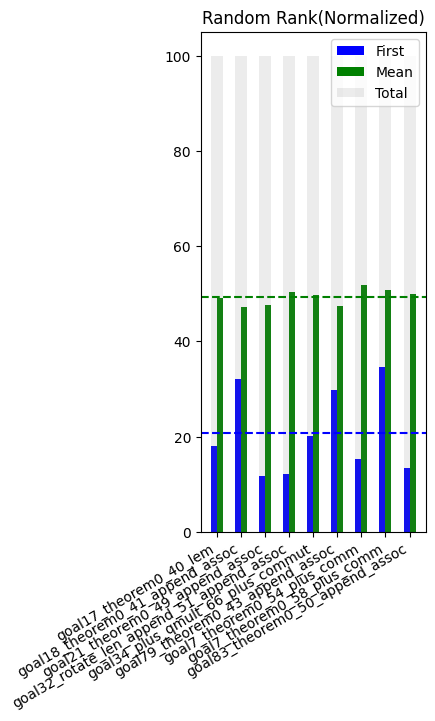

In [169]:
rand_first_ranks, rand_avg_ranks = random_rank(frames)
visualize_ranks("Random Rank", frames, rand_first_ranks, rand_avg_ranks)

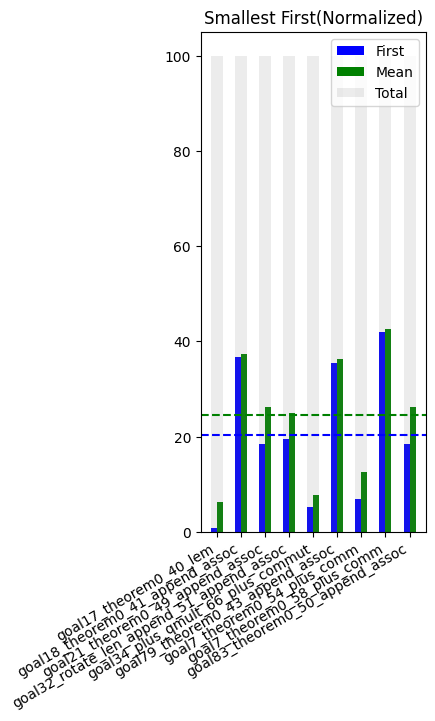

In [170]:
small_first_ranks, small_avg_ranks = smallest_first(frames)
visualize_ranks("Smallest First", frames, small_first_ranks, small_avg_ranks)

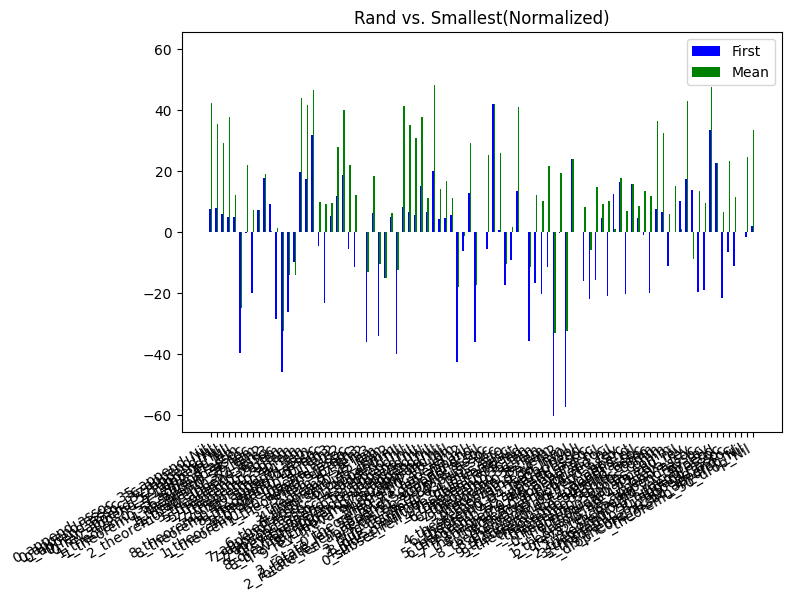

In [12]:
visualize_rank_difference("Rand vs. Smallest", frames, rand_first_ranks, rand_avg_ranks, small_first_ranks, small_avg_ranks, normalize=True)

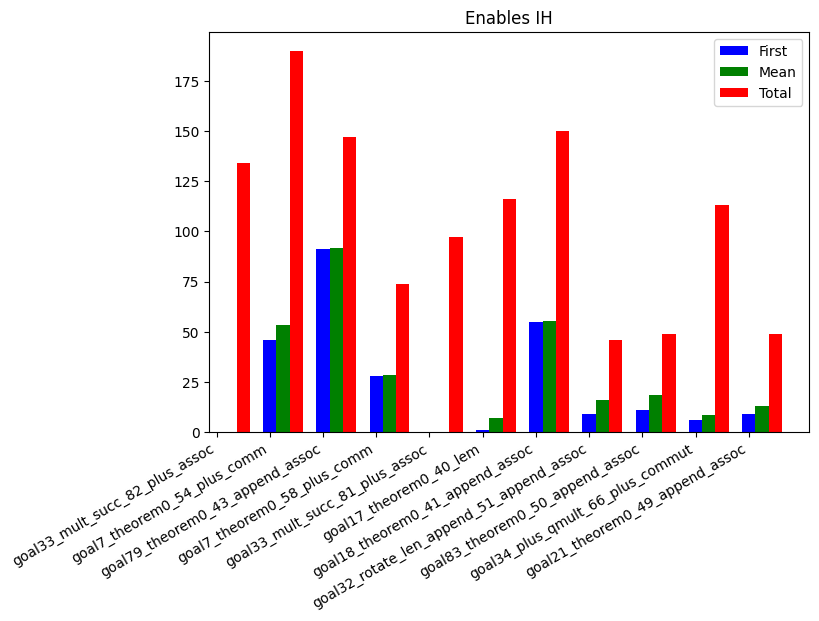

In [17]:
enable_IH_first_rank, enable_IH_avg_rank = enables_IH(frames)
visualize_ranks("Enables IH", frames, enable_IH_first_rank, enable_IH_avg_rank)

In [ ]:
for idx in range(len(frames)):
  print(len(frames[idx][frames[idx]["enables_IH"] == True]), len(frames[idx]))

0 134
155 190
67 147
0 74
0 97
0 116
0 150
20 46
20 49
113 113
0 49


In [174]:
def cat2_first(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for i, _ in frames[index].iterrows():
      frames[index].loc[i, "lemma_len"] = len(frames[index].loc[i, "lemma"])
    all_equiv = []
    sorted_frame = frames[index].sort_values(['cat', 'lemma_len'], ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

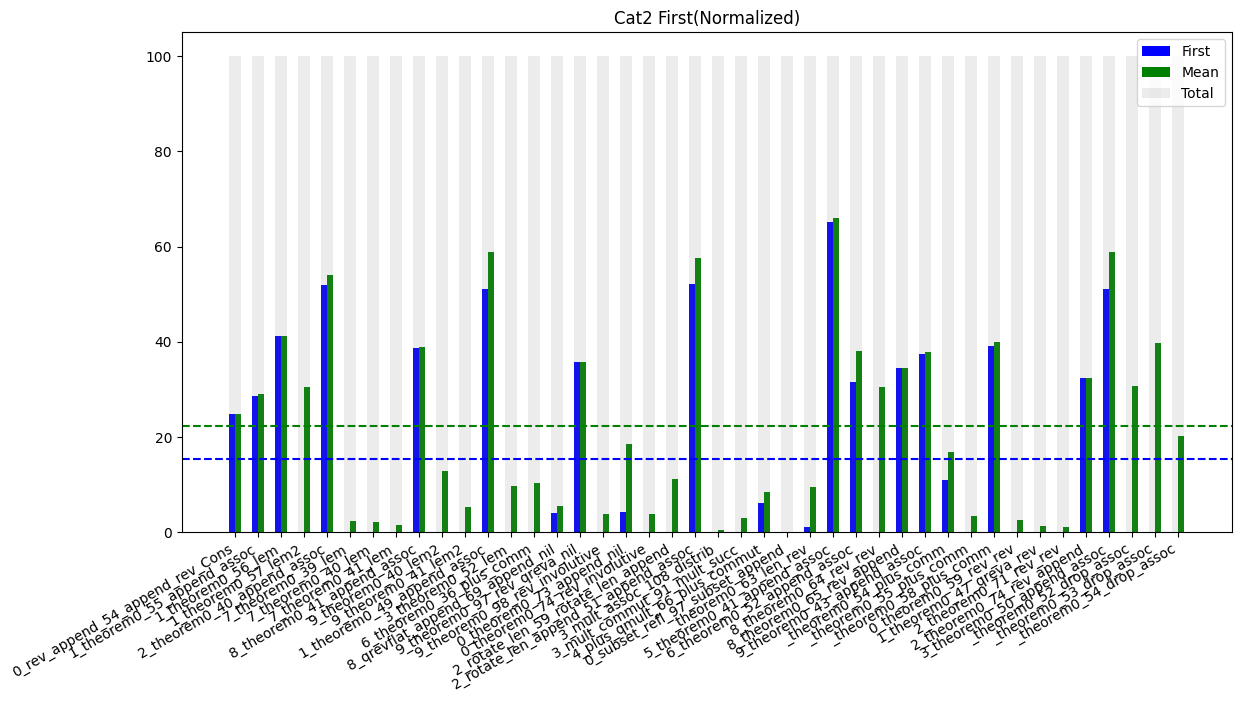

In [175]:
cat2_first_ranks, cat2_avg_ranks = cat2_first(frames)
visualize_ranks("Cat2 First", frames, cat2_first_ranks, cat2_avg_ranks)

In [94]:
import coq_serapy

def disable_notations(prelude, theorem):
    if isinstance(prelude, str):
        prelude = [s.strip() + '.' for s in prelude.strip().split(".")[:-1]]
    with coq_serapy.SerapiContext(
            ["sertop", "--implicit"],
            None,
            "/home/yousef/lemmaranker/benchmark/smallclam") as coq:
        for stmt in prelude:
            coq.run_stmt(stmt.strip('-'))
        coq.run_stmt('Unset Printing Notations.')
        coq.run_stmt(theorem)
        return coq.goals

In [95]:
disable_notations(frames[0].at[0, "prelude"], frames[0].at[0, "theorem"])

'forall x y : natural, @eq natural (plus (mult x y) x) (mult x (Succ y))'

In [132]:
def order_by_sed(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for i, _ in frames[index].iterrows():
      frames[index].loc[i, "sed"] = sed(get_goal(frames[index].loc[i, 'ugly_theorem']), get_goal(frames[index].loc[i, 'ugly_lemma']))
    all_equiv = []
    sorted_frame = frames[index].sort_values(['sed', 'lemma_len'], ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

def order_by_ted(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for i, _ in frames[index].iterrows():
      # frames[index].loc[i, "sexp_lemma"] = sexpdata.loads(f"({get_goal(frames[index].loc[i, 'ugly_lemma'])})")
      frames[index].loc[i, "sexp_lemma_size"] = sexp_size(sexpdata.loads(f"({get_goal(frames[index].loc[i, 'ugly_lemma'])})"))
      frames[index].loc[i, "ted"] = ted(f"({get_goal(frames[index].loc[i, 'ugly_theorem'])})", f"({get_goal(frames[index].loc[i, 'ugly_lemma'])})")
    all_equiv = []
    sorted_frame = frames[index].sort_values(['ted', 'sexp_lemma_size'], ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [158]:
sed_first_ranks = order_by_sed(frames)
ted_first_ranks = order_by_ted(frames)

/tmp/ipykernel_3243/3113902737.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, "sexp_lemma_size"] = sexp_size(sexpdata.loads(f"({get_goal(frames[index].loc[i, 'ugly_lemma'])})"))
/tmp/ipykernel_3243/3113902737.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, "sexp_lemma_size"] = sexp_size(sexpdata.loads(f"({get_goal(frames[index].loc[i, 'ugly_lemma'])})"))
/tmp/ipykernel_3243/3113902737.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [66]:
sexp_size(sexpdata.loads(f"({frames[0].at[0, 'ugly_lemma']})"))

20

In [134]:
def smallest_first(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    all_equiv = []
    sorted_frame = frames[index].sort_values('lemma_len', ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

def smallest_ugly_first(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    all_equiv = []
    sorted_frame = frames[index].sort_values('ugly_lemma_len', ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

def smallest_sexp_first(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    all_equiv = []
    sorted_frame = frames[index].sort_values('sexp_lemma_size', ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [157]:
f1, a1 = smallest_first(frames)
f2, a2 = smallest_ugly_first(frames)
f3, a3 = smallest_sexp_first(frames)

KeyError: 'sexp_lemma_size'

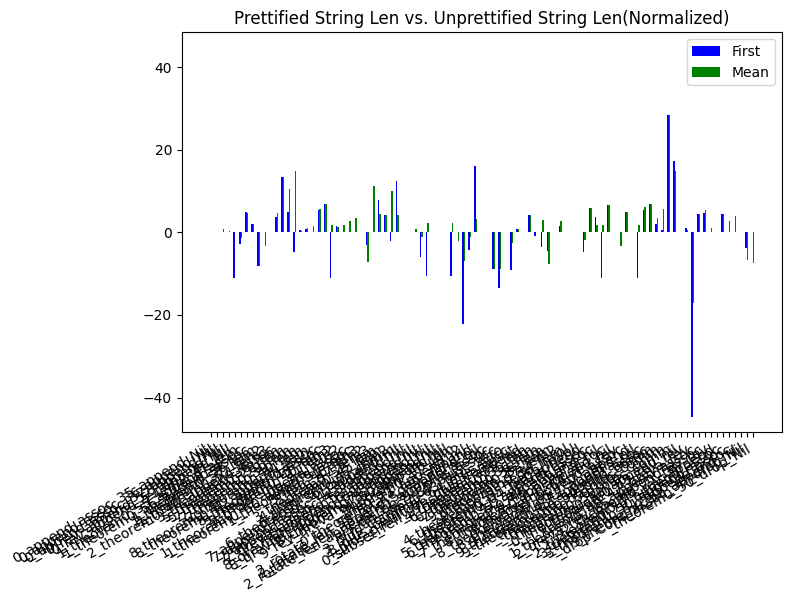

In [19]:
visualize_rank_difference("Prettified String Len vs. Unprettified String Len", frames, f1, a1, f2, a2)

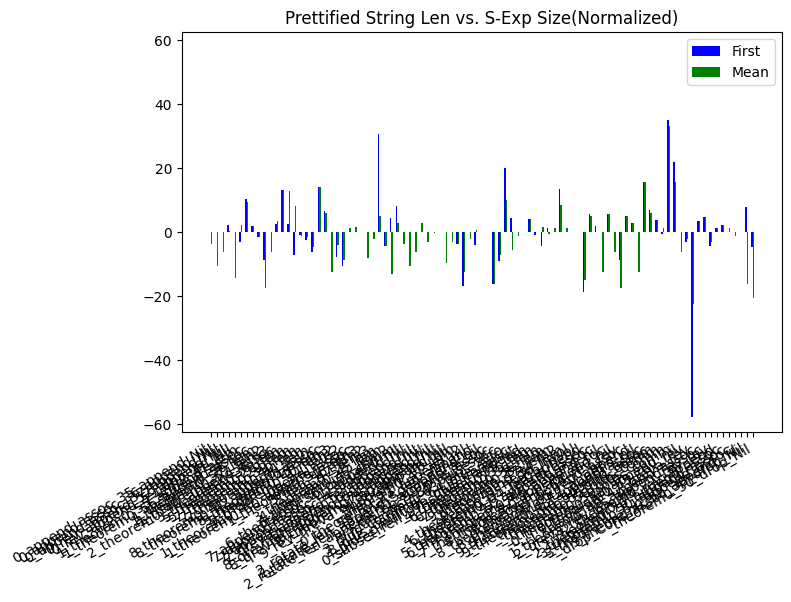

In [20]:
visualize_rank_difference("Prettified String Len vs. S-Exp Size", frames, f1, a1, f3, a3)


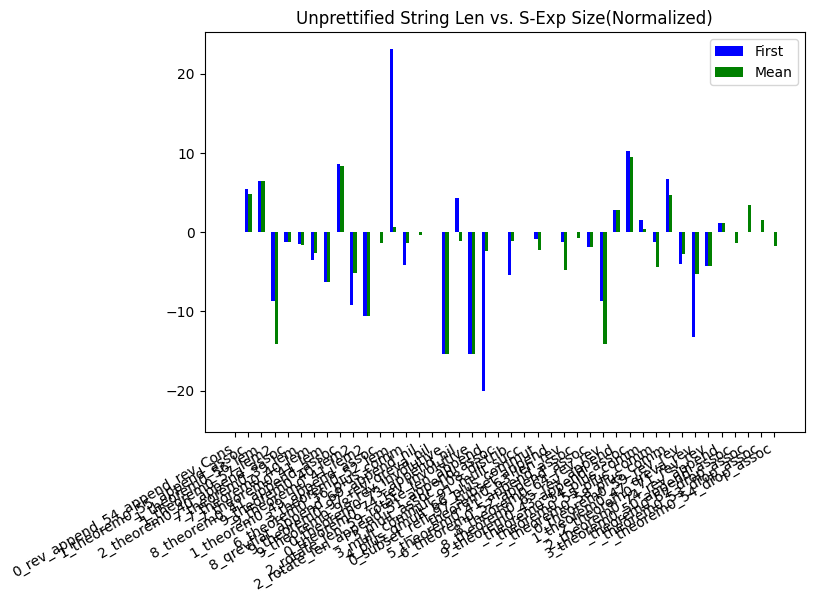

In [136]:
visualize_rank_difference("Unprettified String Len vs. S-Exp Size", frames, f2, a2, f3, a3)


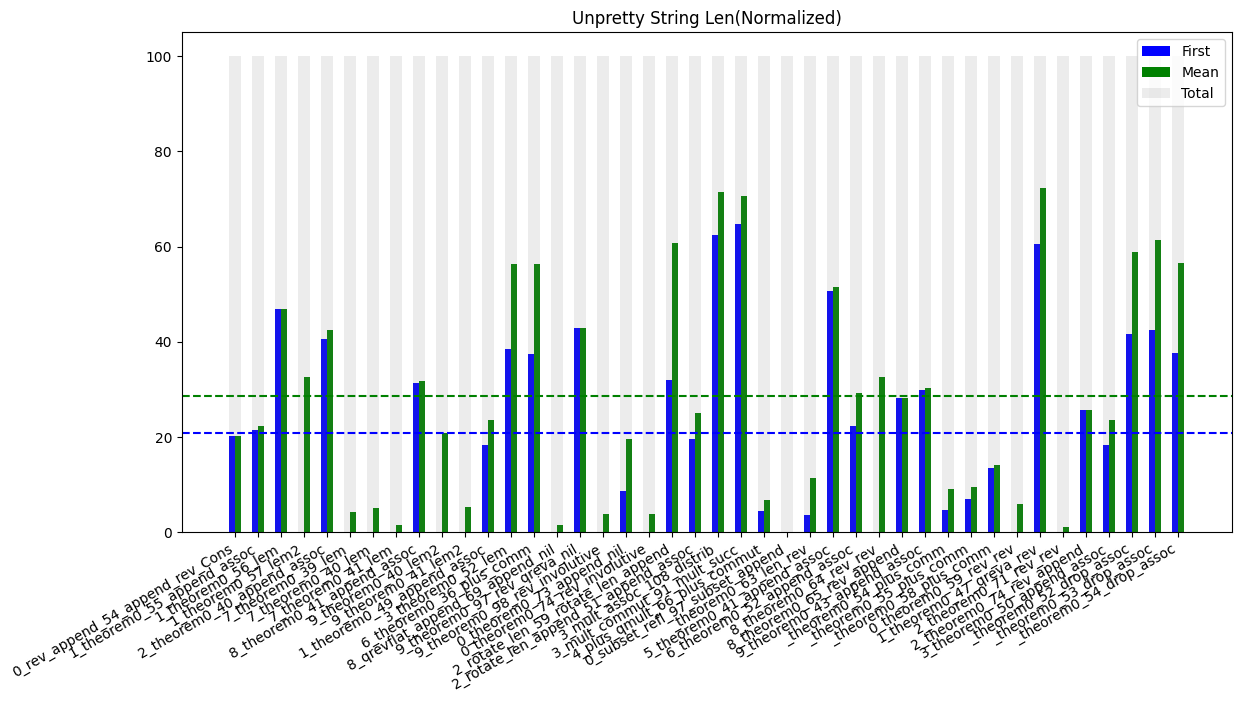

In [137]:
visualize_ranks("Unpretty String Len", frames, f2, a2)

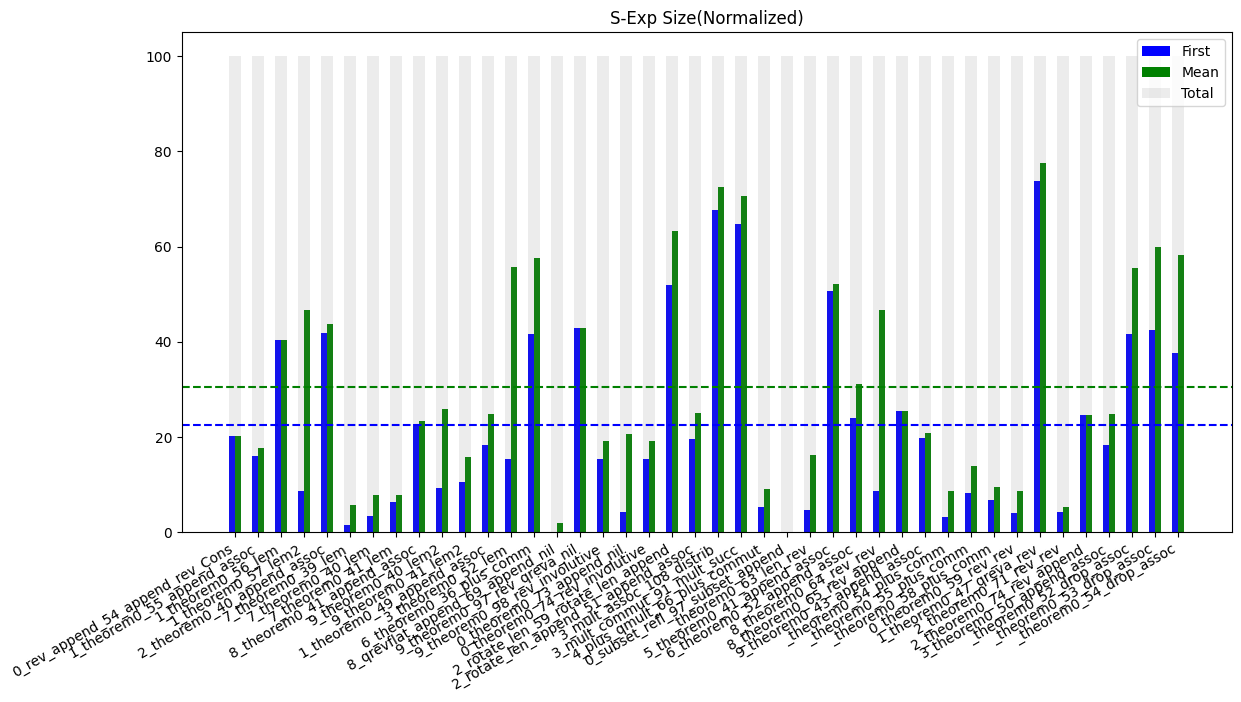

In [138]:
visualize_ranks("S-Exp Size", frames, f3, a3)

In [187]:
sed_f, sed_a = order_by_sed(frames)
ted_f, ted_a = order_by_ted(frames)

/tmp/ipykernel_3243/3113902737.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, "sexp_lemma_size"] = sexp_size(sexpdata.loads(f"({get_goal(frames[index].loc[i, 'ugly_lemma'])})"))
/tmp/ipykernel_3243/3113902737.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, "sexp_lemma_size"] = sexp_size(sexpdata.loads(f"({get_goal(frames[index].loc[i, 'ugly_lemma'])})"))
/tmp/ipykernel_3243/3113902737.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy o

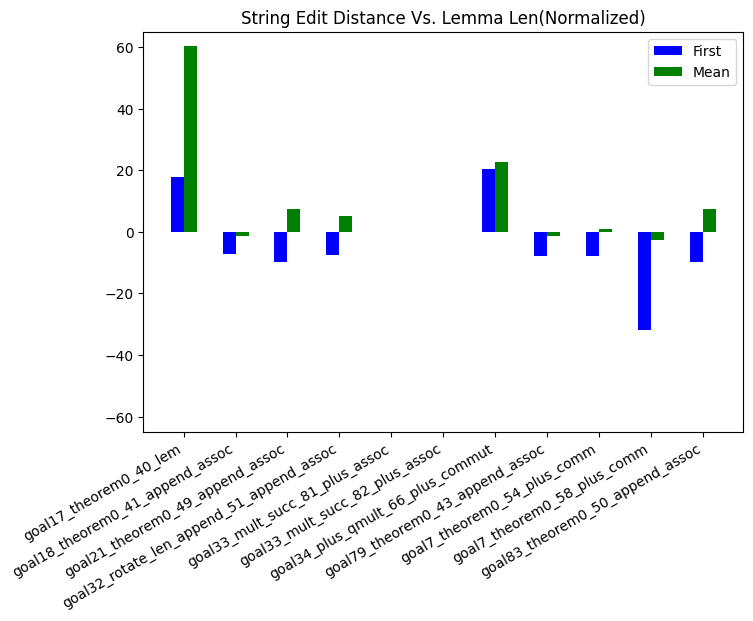

In [165]:
visualize_rank_difference("String Edit Distance Vs. Lemma Len", frames, sed_f, sed_a, a1, a2)

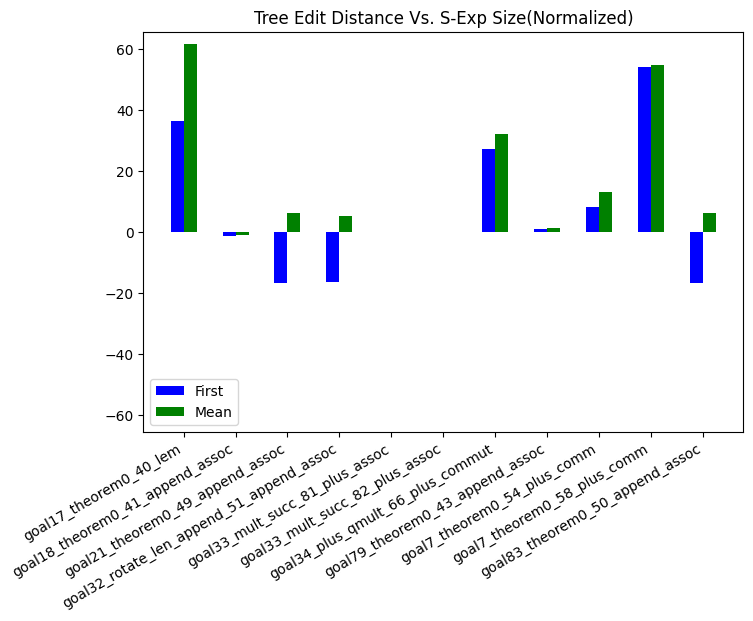

In [167]:
visualize_rank_difference("Tree Edit Distance Vs. S-Exp Size", frames, ted_f, ted_a, a3, a3)

In [138]:
ordered_frames = sorted(frames, key=lambda frame: frame.file[0])


In [140]:
for frame in ordered_frames:
  print(frame.file[0])

smallclam_lf_goal17_theorem0_40_lem
smallclam_lf_goal18_theorem0_41_append_assoc
smallclam_lf_goal21_theorem0_49_append_assoc
smallclam_lf_goal32_rotate_len_append_51_append_assoc
smallclam_lf_goal33_mult_succ_81_plus_assoc
smallclam_lf_goal33_mult_succ_82_plus_assoc
smallclam_lf_goal34_plus_qmult_66_plus_commut
smallclam_lf_goal79_theorem0_43_append_assoc
smallclam_lf_goal7_theorem0_54_plus_comm
smallclam_lf_goal7_theorem0_58_plus_comm
smallclam_lf_goal83_theorem0_50_append_assoc


In [161]:
frames = sorted(frames, key=lambda frame: frame.file[0])


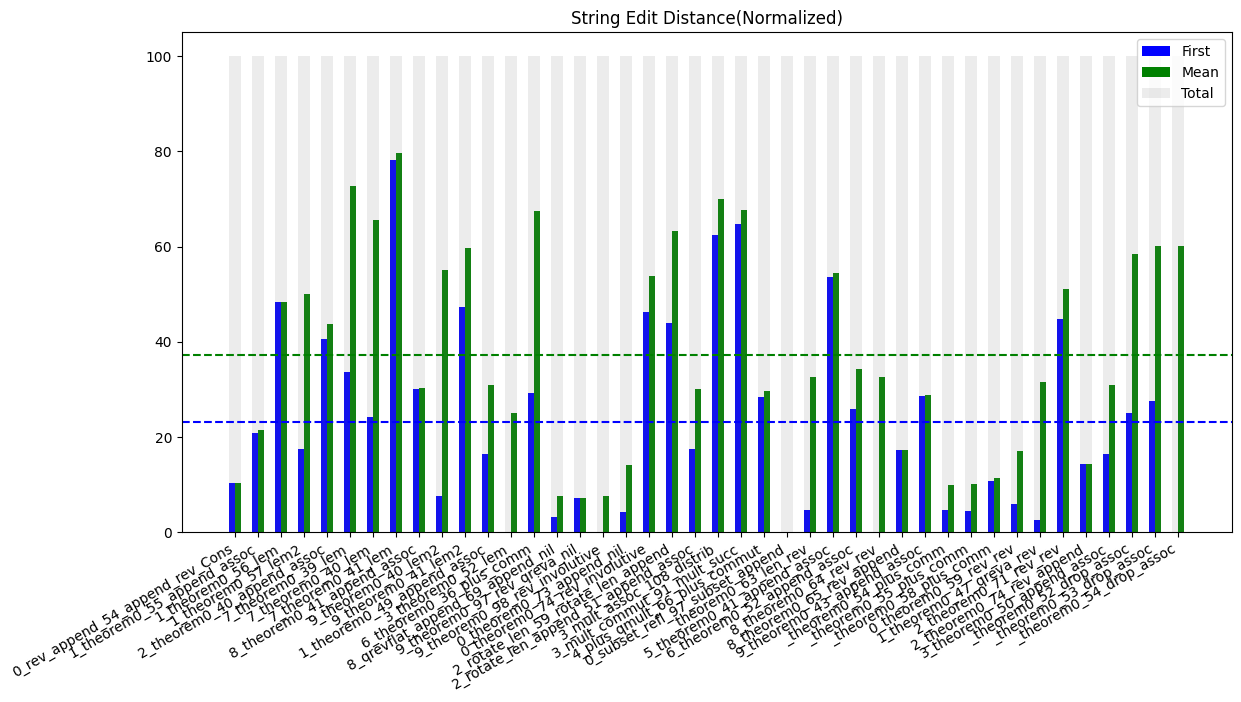

In [140]:
visualize_ranks("String Edit Distance", frames, sed_f, sed_a)

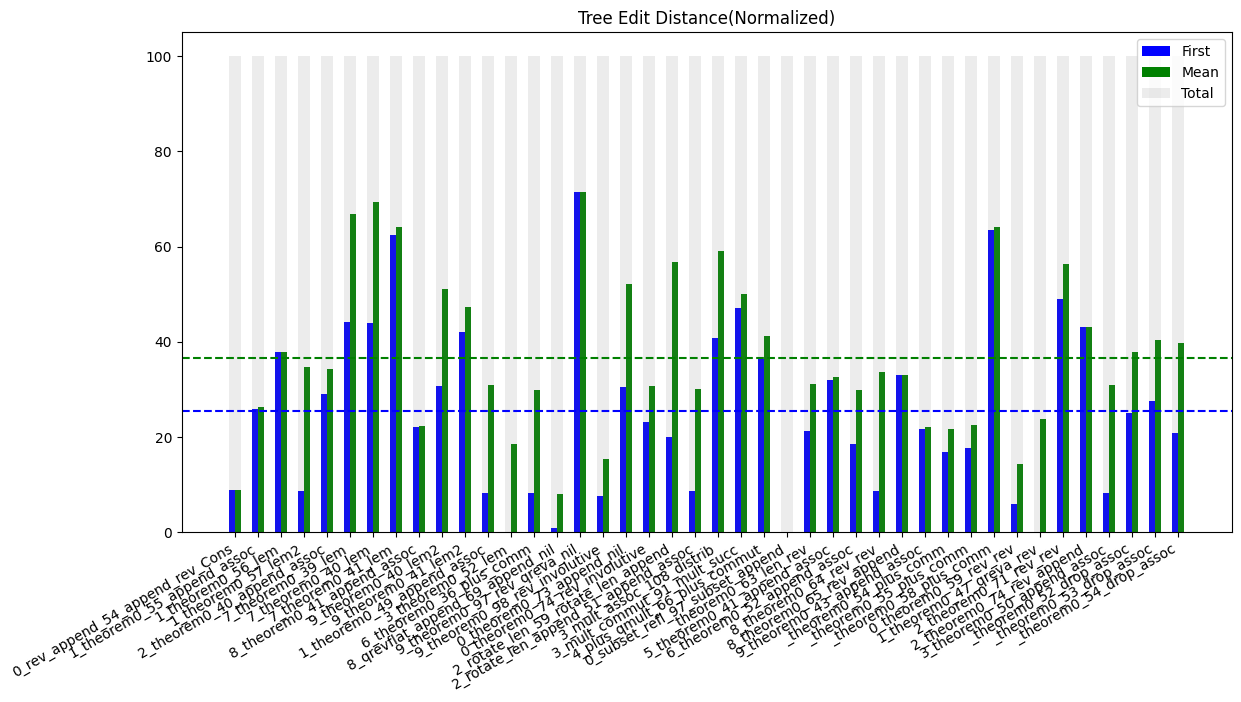

In [141]:
visualize_ranks("Tree Edit Distance", frames, ted_f, ted_a)


In [66]:
counter = 0
no_cat_1_frames = []
for frame in frames:
  if 1.0 in frame["cat"].unique():
    counter += 1
  else:
    no_cat_1_frames.append(frame)


In [71]:
all_frames = frames

In [62]:
frames = all_frames

False

In [72]:
frames = no_cat_1_frames

In [96]:
from collections import Counter
cnt = Counter()
for frame in frames:
  cnt[len(frame[frame['is_equiv'] == True])] += 1

cnt

Counter({1: 6, 3: 2, 4: 10, 2: 11, 6: 9, 5: 1, 8: 1, 7: 1, 21: 1})

In [14]:
frames[0][['cat','lemma_len', 'ugly_lemma_len',	'sed',	'ted',	'sexp_lemma_size']], frames[0][['is_equiv']]

KeyError: "['sexp_lemma_size'] not in index"

In [7]:
frame['theorem_proof'][0]

'Proof.intros.rewrite (drop_assoc w x).rewrite (drop_assoc w y).lfind.Admitted.'

In [189]:
from sklearn.linear_model import LogisticRegression
merged = pd.concat(frames)

In [190]:
features = ['lemma_len', 'ugly_lemma_len', 'sexp_lemma_size', 'sed',	'ted', 'alpha']
X, y = merged[features], merged[['is_equiv']]
Xtrain, ytrain = X[X['alpha'] <= 0.8], y[X['alpha'] <= 0.8]
Xtest, ytest = X[X['alpha'] > 0.8], y[X['alpha'] > 0.8]

In [191]:
clf = LogisticRegression().fit(X.values.tolist(), y.values.tolist())
print(clf.score(X.values.tolist(), y.values.tolist()))
print(clf.score(X[y['is_equiv'] == 0].values.tolist(), y[y['is_equiv'] == 0].values.tolist()))
print(clf.score(X[y['is_equiv'] == 1].values.tolist(), y[y['is_equiv'] == 1].values.tolist()))

/home/yousef/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9486009732360098
1.0
0.0


In [192]:
clf = LogisticRegression().fit(Xtrain.values.tolist(), ytrain.values.tolist())
print(clf.score(Xtrain.values.tolist(), ytrain.values.tolist()))
print(clf.score(Xtest.values.tolist(), ytest.values.tolist()))
print(clf.score(Xtest[ytest['is_equiv'] == 0].values.tolist(), ytest[ytest['is_equiv'] == 0].values.tolist()))
print(clf.score(Xtest[ytest['is_equiv'] == 1].values.tolist(), ytest[ytest['is_equiv'] == 1].values.tolist()))

/home/yousef/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9471639471639471
0.9537815126050421
1.0
0.0


In [193]:
y[y['is_equiv'] == 1]

,is_equiv
52,True
38,True
39,True
40,True
44,True
...,...
17,True
18,True
19,True
20,True


In [194]:
len(y[y['is_equiv'] == 1])/len(y)

0.05139902676399027

In [195]:
Xtrain

,lemma_len,ugly_lemma_len,sexp_lemma_size,sed,ted,alpha
0,185.0,149.0,19.0,57.0,21.0,0.442337
1,198.0,162.0,21.0,70.0,25.0,0.440247
2,198.0,162.0,21.0,70.0,25.0,0.408797
4,210.0,166.0,21.0,70.0,29.0,0.638698
5,182.0,165.0,21.0,61.0,25.0,0.579831
...,...,...,...,...,...,...
46,182.0,127.0,16.0,26.0,8.0,0.538121
47,181.0,127.0,16.0,26.0,8.0,0.432861
48,181.0,127.0,16.0,26.0,8.0,0.149813
50,177.0,127.0,16.0,26.0,8.0,0.022194


In [196]:
Xtest

,lemma_len,ugly_lemma_len,sexp_lemma_size,sed,ted,alpha
3,198.0,162.0,21.0,70.0,25.0,0.803572
7,227.0,190.0,23.0,87.0,35.0,0.912902
9,77.0,45.0,6.0,33.0,12.0,0.959849
10,78.0,46.0,6.0,33.0,15.0,0.880763
12,84.0,46.0,6.0,33.0,15.0,0.972225
...,...,...,...,...,...,...
34,114.0,85.0,10.0,32.0,20.0,0.936629
35,114.0,85.0,10.0,32.0,20.0,0.861680
43,115.0,78.0,11.0,40.0,26.0,0.925764
49,181.0,127.0,16.0,26.0,8.0,0.886753


In [197]:
print(clf.score(X[y['is_equiv'] == 1].values.tolist(), y[y['is_equiv'] == 1].values.tolist()))

0.0


In [198]:
results = clf.predict_proba(X.values.tolist())

In [199]:
tmp = merged
tmp["prob_not_equiv"], tmp["prob_equiv"] = [res[0] for res in results], [res[1] for res in results]

In [200]:
frames = []
for filename in tmp["file"].unique():
  frame = tmp[tmp["file"] == filename]
  if 1 in frame['cat'].unique():
    continue
  elif frame['is_equiv'].any():
    frames.append(frame)
  else:
    print(f"Excluding file: {filename} because none of the synthesized lemmas are equivalent to human lemma")
frames = sorted(frames, key=lambda frame: frame.file[0])
for frame in frames:
  print(frame.at[0, 'file'])

def order_by_prob_equiv(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    all_equiv = []
    sorted_frame = frames[index].sort_values(['prob_not_equiv'], ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

prob_equiv_first, prob_equiv_avg = order_by_prob_equiv(frames)

clam_lf_goal10_rev_append_54_append_rev_Cons
clam_lf_goal11_theorem0_55_append_assoc
clam_lf_goal11_theorem0_56_lem
clam_lf_goal11_theorem0_57_lem2
clam_lf_goal12_theorem0_40_append_assoc
clam_lf_goal17_theorem0_39_lem
clam_lf_goal17_theorem0_40_lem
clam_lf_goal17_theorem0_41_lem
clam_lf_goal18_theorem0_41_append_assoc
clam_lf_goal19_theorem0_40_lem2
clam_lf_goal19_theorem0_41_lem2
clam_lf_goal21_theorem0_49_append_assoc
clam_lf_goal23_theorem0_52_lem
clam_lf_goal26_theorem0_36_plus_comm
clam_lf_goal28_qrevflat_append_69_append_nil
clam_lf_goal29_theorem0_97_rev_qreva_nil
clam_lf_goal29_theorem0_98_rev_involutive
clam_lf_goal30_theorem0_73_append_nil
clam_lf_goal30_theorem0_74_rev_involutive
clam_lf_goal32_rotate_len_59_rotate_len_append
clam_lf_goal32_rotate_len_append_51_append_assoc
clam_lf_goal33_mult_assoc_108_distrib
clam_lf_goal33_mult_commut_91_mult_succ
clam_lf_goal34_plus_qmult_66_plus_commut
clam_lf_goal40_subset_refl_97_subset_append
clam_lf_goal6_theorem0_63_len_rev
clam_l

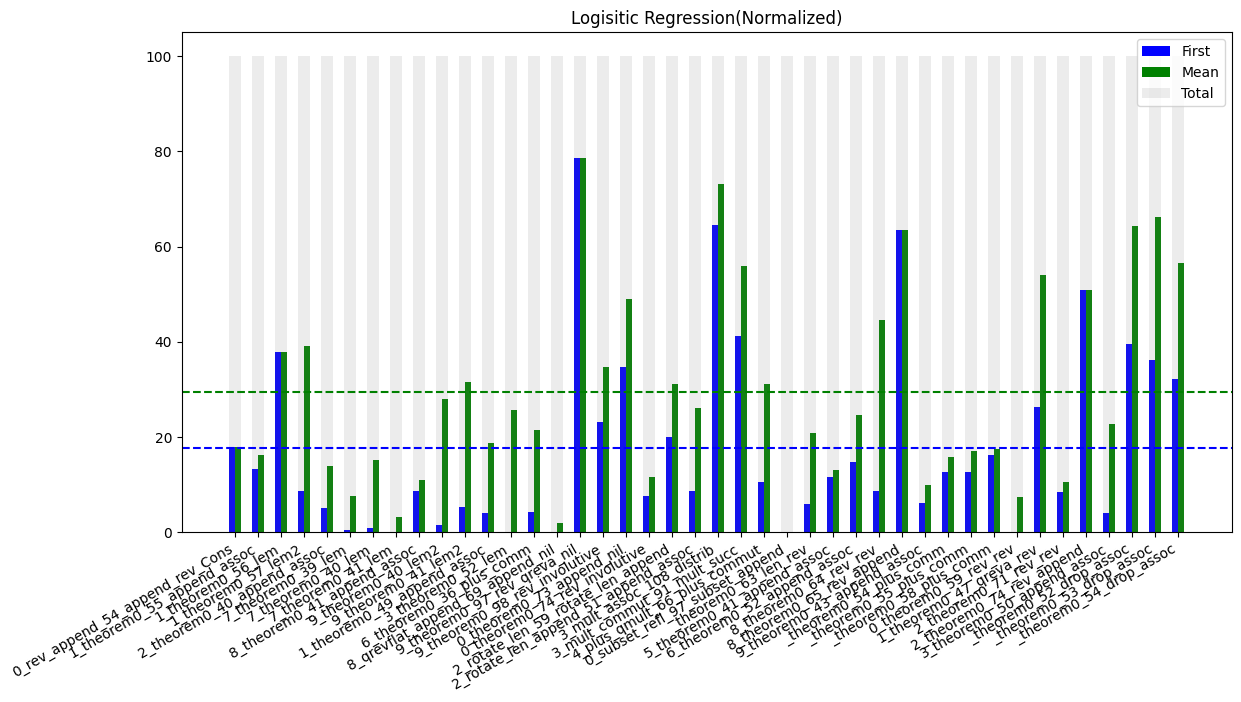

In [201]:
visualize_ranks("Logisitic Regression", frames, prob_equiv_first, prob_equiv_avg)

In [10]:
frames[0]

,cat,lemma,lemma_name,file,theorem_name,helper_lemma_name,prelude,stuck_state,prefix,helper_lemma,...,ugly_lemma,ugly_theorem,ugly_helper_lemma,lemma_len,ugly_lemma_len,is_weaker,is_stronger,is_equiv,sed,ted
0,2,Lemma conj1synthconj1 : forall (lv0 : lst) (l...,conj1synthconj1,smallclam_lf_goal17_theorem0_40_lem,theorem0,lem,./benchmark/smallclam/smallclam,Lemma lfind_state (x:lst) (y:lst):@eq lst (ap...,Load LFindLoad.\nFrom lfind Require Import LFi...,"Lemma lem: forall l, rev (rev l) = l.",...,"forall lv0 _ : lst, @eq lst (rev (rev lv0)) lv0","forall x y : lst,\n@eq lst (rev (rev (append x...","forall l : lst, @eq lst (rev (rev l)) l",87.0,47.0,True,False,False,0.0,0.0
1,2,Lemma conj1synthconj4 : forall (lv0 : lst) (l...,conj1synthconj4,smallclam_lf_goal17_theorem0_40_lem,theorem0,lem,./benchmark/smallclam/smallclam,Lemma lfind_state (x:lst) (y:lst):@eq lst (ap...,Load LFindLoad.\nFrom lfind Require Import LFi...,"Lemma lem: forall l, rev (rev l) = l.",...,"forall (_ : lst) (lv1 : lst), @eq lst lv1 (rev...","forall x y : lst,\n@eq lst (rev (rev (append x...","forall l : lst, @eq lst (rev (rev l)) l",87.0,57.0,True,False,False,0.0,0.0
2,2,Lemma conj11eqsynthconj5 : forall (lv0 : lst)...,conj11eqsynthconj5,smallclam_lf_goal17_theorem0_40_lem,theorem0,lem,./benchmark/smallclam/smallclam,Lemma lfind_state (x:lst) (y:lst):@eq lst (ap...,Load LFindLoad.\nFrom lfind Require Import LFi...,"Lemma lem: forall l, rev (rev l) = l.",...,"forall lv0 : lst, @eq lst lv0 (rev (rev lv0))","forall x y : lst,\n@eq lst (rev (rev (append x...","forall l : lst, @eq lst (rev (rev l)) l",82.0,45.0,True,True,True,0.0,0.0
3,2,Lemma conj19eqsynthconj6 : forall (lv0 : lst)...,conj19eqsynthconj6,smallclam_lf_goal17_theorem0_40_lem,theorem0,lem,./benchmark/smallclam/smallclam,Lemma lfind_state (x:lst) (y:lst):@eq lst (ap...,Load LFindLoad.\nFrom lfind Require Import LFi...,"Lemma lem: forall l, rev (rev l) = l.",...,"forall lv0 : lst, @eq lst (rev (rev lv0)) lv0","forall x y : lst,\n@eq lst (rev (rev (append x...","forall l : lst, @eq lst (rev (rev l)) l",82.0,45.0,True,True,True,0.0,0.0
4,2,Lemma conj19eqsynthconj4 : forall (lv0 : lst)...,conj19eqsynthconj4,smallclam_lf_goal17_theorem0_40_lem,theorem0,lem,./benchmark/smallclam/smallclam,Lemma lfind_state (x:lst) (y:lst):@eq lst (ap...,Load LFindLoad.\nFrom lfind Require Import LFi...,"Lemma lem: forall l, rev (rev l) = l.",...,"forall lv0 : lst, @eq lst (rev (rev lv0)) (app...","forall x y : lst,\n@eq lst (rev (rev (append x...","forall l : lst, @eq lst (rev (rev l)) l",93.0,58.0,True,True,True,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,3,Lemma conj10eqsynthconj1 : forall (lv0 : lst)...,conj10eqsynthconj1,smallclam_lf_goal17_theorem0_40_lem,theorem0,lem,./benchmark/smallclam/smallclam,Lemma lfind_state (x:lst) (y:lst):@eq lst (ap...,Load LFindLoad.\nFrom lfind Require Import LFi...,"Lemma lem: forall l, rev (rev l) = l.",...,"forall lv0 lv1 : lst,\n@eq lst (append (rev (r...","forall x y : lst,\n@eq lst (rev (rev (append x...","forall l : lst, @eq lst (rev (rev l)) l",143.0,102.0,False,False,False,0.0,0.0
112,3,Lemma conj9eqsynthconj4 : forall (lv0 : lst) ...,conj9eqsynthconj4,smallclam_lf_goal17_theorem0_40_lem,theorem0,lem,./benchmark/smallclam/smallclam,Lemma lfind_state (x:lst) (y:lst):@eq lst (ap...,Load LFindLoad.\nFrom lfind Require Import LFi...,"Lemma lem: forall l, rev (rev l) = l.",...,"forall lv0 lv1 : lst,\n@eq lst (append (rev (r...","forall x y : lst,\n@eq lst (rev (rev (append x...","forall l : lst, @eq lst (rev (rev l)) l",141.0,101.0,False,False,False,0.0,0.0
113,3,Lemma conj9eqsynthconj3 : forall (lv0 : lst) ...,conj9eqsynthconj3,smallclam_lf_goal17_theorem0_40_lem,theorem0,lem,./benchmark/smallclam/smallclam,Lemma lfind_state (x:lst) (y:lst):@eq lst (ap...,Load LFindLoad.\nFrom lfind Require Import LFi...,"Lemma lem: forall l, rev (rev l) = l.",...,"forall lv0 lv1 : lst,\n@eq lst (append (rev (r...","forall x y : lst,\n@eq lst (

In [18]:
frames[0].at[0, 'theorem_proof'].replace('.', '. ')

'Proof. intros.  rewrite lem. lfind. Admitted. '

In [19]:
coq_serapy.read_commands(frames[0].at[0, 'theorem_proof'].replace('.', '. '))

['Proof. ', 'intros. ', ' rewrite lem. ', 'lfind. ', 'Admitted. ']

In [24]:
ex_row = frames[0].iloc[0]

In [33]:
def split_theorem_proof(frame, index):
  proof_cmds = coq_serapy.read_commands(frame.at[index, "theorem_proof"].replace('.', '. '))
  proof_cmds_before = []
  proof_cmds_after = []
  found = False
  for cmd in proof_cmds:
    if 'lfind.' in cmd:
      found = True
      continue
    if not found:
      proof_cmds_before.append(cmd)
    else:
      proof_cmds_after.append(cmd)
  return proof_cmds_before, proof_cmds_after
  

In [34]:
split_theorem_proof(frames[0], 0)

(['Proof. ', 'intros. ', ' rewrite lem. '], ['Admitted. '])

In [87]:
def get_IHs(frame, index):
  prelude = frame.at[index, 'prelude']
  prefix = coq_serapy.read_commands(frame.at[index, 'prefix'])
  helper_lemma = frame.at[index, 'helper_lemma']
  helper_lemma_proof = coq_serapy.read_commands(frame.at[index, 'helper_lemma_proof'].replace('.', '. '))
  theorem = frame.at[index, 'theorem']
  proof_cmds_before, _ = split_theorem_proof(frame, index)

  with coq_serapy.SerapiContext(
          ["sertop", "--implicit"],    
          None,
          prelude) as coq:
    for stmt in prefix:
        coq.run_stmt(stmt)
    coq.run_stmt(helper_lemma)
    for cmd in helper_lemma_proof:
        coq.run_stmt(cmd)
    coq.run_stmt(theorem)

    for cmd in proof_cmds_before:
        coq.run_stmt(cmd)
    IHs = []
    for hyp in coq.hypotheses:
        if hyp.startswith('IH'):
            IHs.append(hyp.split(":")[0].strip())
    return IHs


In [88]:
def uses_IHs_before(frame, index):
  IHs = get_IHs(frame, index)
  print(IHs)
  cmds_before, _ = split_theorem_proof(frame, index)
  print(cmds_before)
  for cmd in cmds_before:
    for ih in IHs:
      if ih in cmd:
        return True
  return False

In [149]:

def can_use_tactic(prelude, prefix, theorem, proof_cmds, tactic):
  with coq_serapy.SerapiContext(
          ["sertop", "--implicit"],    
          None,
          prelude) as coq:
    for stmt in prefix:
        coq.run_stmt(stmt)
    coq.run_stmt(theorem)
    for cmd in proof_cmds:
        coq.run_stmt(cmd)
    try:
      coq.run_stmt(tactic)
      return True
    except:
      return False  

def can_use_helper(prelude, prefix, theorem, proof_cmds, helper):
  return can_use_tactic(prelude, prefix, theorem, proof_cmds, f'apply {helper} || rewrite {helper} || rewrite <- {helper} || fail.')

def can_use_IH_before(frame, index):
  prelude = frame.at[index, 'prelude']
  prefix = coq_serapy.read_commands(frame.at[index, 'prefix'])
  helper_lemma = frame.at[index, 'helper_lemma']
  helper_lemma_proof = coq_serapy.read_commands(frame.at[index, 'helper_lemma_proof'].replace('.', '. '))
  theorem = frame.at[index, 'theorem']
  proof_cmds_before, _ = split_theorem_proof(frame, index)
  IHs = get_IHs(frame, index)
  return any(can_use_helper(prelude, prefix + [helper_lemma] + helper_lemma_proof, theorem, proof_cmds_before, ih) for ih in IHs)

def can_use_IH_after(frame, index):
  if can_use_synth(frame, index):
    prelude = frame.at[index, 'prelude']
    prefix = coq_serapy.read_commands(frame.at[index, 'prefix'])
    helper_lemma = frame.at[index, 'helper_lemma']
    helper_lemma_proof = coq_serapy.read_commands(frame.at[index, 'helper_lemma_proof'].replace('.', '. '))
    synth_lemma = frame.at[index, 'lemma']
    synth_lemma_name = frame.at[index, 'lemma_name']
    theorem = frame.at[index, 'theorem']
    proof_cmds_before, _ = split_theorem_proof(frame, index)
    IHs = get_IHs(frame, index)
    return any(can_use_helper(prelude, 
                          prefix + [helper_lemma] + helper_lemma_proof + [synth_lemma, 'Admitted.'], 
                          theorem, 
                          proof_cmds_before + [f'apply {synth_lemma_name} || rewrite {synth_lemma_name} || rewrite <- {synth_lemma_name} || fail.'], 
                          ih) for ih in IHs)
  else:
    return False

def can_use_synth(frame, index):
  prelude = frame.at[index, 'prelude']
  prefix = coq_serapy.read_commands(frame.at[index, 'prefix'])
  helper_lemma = frame.at[index, 'helper_lemma']
  helper_lemma_proof = coq_serapy.read_commands(frame.at[index, 'helper_lemma_proof'].replace('.', '. '))
  synth_lemma = frame.at[index, 'lemma']
  synth_lemma_name = frame.at[index, 'lemma_name']
  theorem = frame.at[index, 'theorem']
  proof_cmds_before, _ = split_theorem_proof(frame, index)
  return can_use_helper(prelude, prefix + [helper_lemma] + helper_lemma_proof + [synth_lemma, 'Admitted.'], theorem, proof_cmds_before, synth_lemma_name)

def can_simpl_before(frame, index):
  prelude = frame.at[index, 'prelude']
  prefix = coq_serapy.read_commands(frame.at[index, 'prefix'])
  helper_lemma = frame.at[index, 'helper_lemma']
  helper_lemma_proof = coq_serapy.read_commands(frame.at[index, 'helper_lemma_proof'].replace('.', '. '))
  theorem = frame.at[index, 'theorem']
  proof_cmds_before, _ = split_theorem_proof(frame, index)
  return can_use_tactic(prelude, prefix + [helper_lemma] + helper_lemma_proof, theorem, proof_cmds_before, 'simpl || fail.')

def can_simpl_after(frame, index):
  if can_use_synth(frame, index):
    prelude = frame.at[index, 'prelude']
    prefix = coq_serapy.read_commands(frame.at[index, 'prefix'])
    helper_lemma = frame.at[index, 'helper_lemma']
    helper_lemma_proof = coq_serapy.read_commands(frame.at[index, 'helper_lemma_proof'].replace('.', '. '))
    synth_lemma = frame.at[index, 'lemma']
    synth_lemma_name = frame.at[index, 'lemma_name']
    theorem = frame.at[index, 'theorem']
    proof_cmds_before, _ = split_theorem_proof(frame, index)
    return can_use_tactic(prelude, 
                          prefix + [helper_lemma] + helper_lemma_proof + [synth_lemma, 'Admitted.'], 
                          theorem, 
                          proof_cmds_before + [f'apply {synth_lemma_name} || rewrite {synth_lemma_name} || rewrite <- {synth_lemma_name} || fail.'], 
                          'simpl || fail.')
  else:
    return False


In [135]:
split_theorem_proof(frames[6], 0)

(['Proof. ', 'induction x; induction y; simpl; try reflexivity. ', '+'],
 ['  simpl. ', 'Admitted. '])

In [159]:
can_simpl_after(frames[0], 0)

False

In [85]:
frames[3].at[0, 'file']

'smallclam_lf_goal32_rotate_len_append_51_append_assoc'